In [1]:

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import re
import string as s

from nltk.corpus import stopwords
from sklearn.metrics import make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix, roc_curve, auc

from nltk.corpus import stopwords
from wordcloud import WordCloud

from sklearn.feature_extraction.text  import TfidfVectorizer
from sklearn.metrics  import f1_score,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier


In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/ag-news-classification-dataset/train.csv
/kaggle/input/ag-news-classification-dataset/test.csv


In [3]:

train_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/train.csv', header=0,names=['ID','Title','Desc'])
test_data = pd.read_csv('/kaggle/input/ag-news-classification-dataset/test.csv', header=0,names=['ID','Title','Desc'])
#df = pd.concat([train_data,test_data])

train_data['text'] = train_data['Title'] + ' ' + train_data['Desc']
test_data['text'] = test_data['Title'] + ' ' + test_data['Desc']


In [4]:
train_data.head()

,ID,Title,Desc,text
0,3,Wall St. Bears Claw Back Into the Black (Reuters),"Reuters - Short-sellers, Wall Street's dwindli...",Wall St. Bears Claw Back Into the Black (Reute...
1,3,Carlyle Looks Toward Commercial Aerospace (Reu...,Reuters - Private investment firm Carlyle Grou...,Carlyle Looks Toward Commercial Aerospace (Reu...
2,3,Oil and Economy Cloud Stocks' Outlook (Reuters),Reuters - Soaring crude prices plus worries\ab...,Oil and Economy Cloud Stocks' Outlook (Reuters...
3,3,Iraq Halts Oil Exports from Main Southern Pipe...,Reuters - Authorities have halted oil export\f...,Iraq Halts Oil Exports from Main Southern Pipe...
4,3,"Oil prices soar to all-time record, posing new...","AFP - Tearaway world oil prices, toppling reco...","Oil prices soar to all-time record, posing new..."


In [5]:

test_data.head()

print(train_data.shape)
print(test_data.shape)

(120000, 4)
(7600, 4)


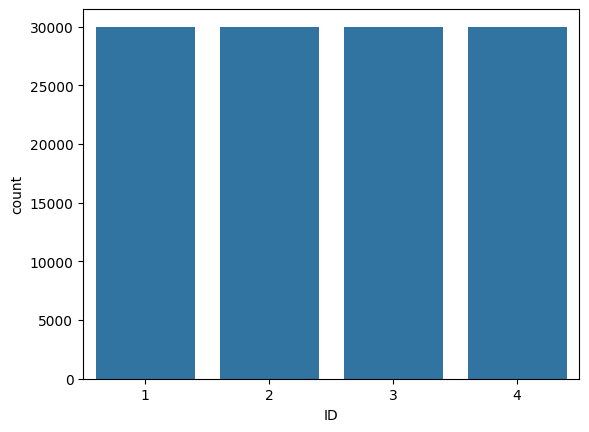

In [6]:

sns.countplot(x = 'ID', data = train_data)
plt.show()


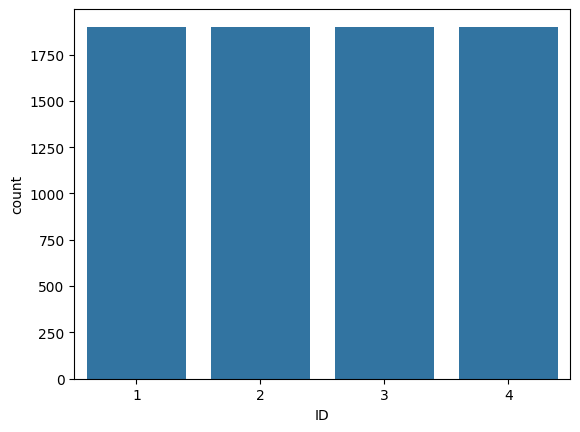

In [7]:
sns.countplot(x = 'ID', data = test_data)
plt.show()


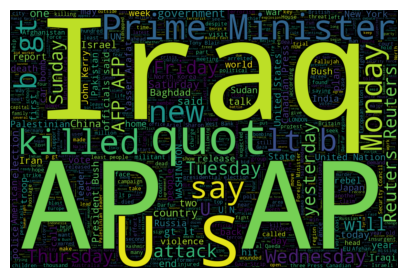

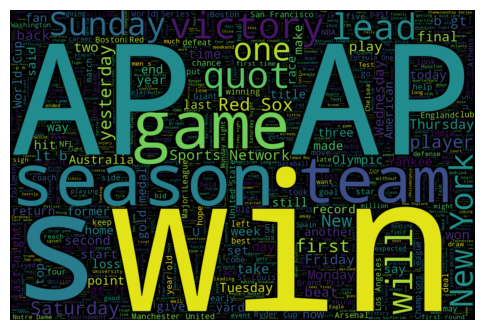

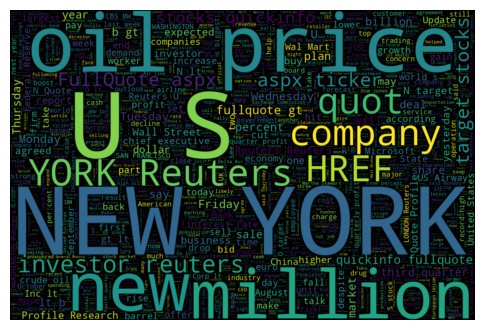

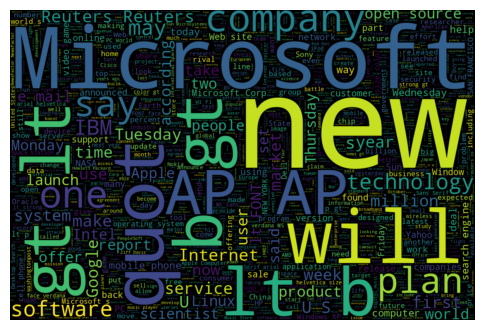

In [8]:


train_x = train_data.text[:60000]
test_x = test_data.text
train_y = train_data.ID[:60000]
test_y = test_data.ID

world = train_data[train_data['ID'] == 1]['text']
plt.figure(figsize=(5, 5))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(world))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

sports_desc = train_data.loc[train_data['ID'] == 2, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sports_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

biz_desc = train_data.loc[train_data['ID'] == 3, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(biz_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

sci_desc = train_data.loc[train_data['ID'] == 4, 'text']
plt.figure(figsize=(6, 6))
wordcloud = WordCloud(min_font_size=3, max_words=2500, width=1200, height=800).generate(" ".join(sci_desc))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()



In [9]:
import html
import re

def clean_html_noise(text: str) -> str:
   
    text = html.unescape(text)
    
   
    text = re.sub(r"<.*?>", "", text)
    
  
    text = re.sub(r"\s+", " ", text).strip()
    
    return text

train_x = train_x.apply(clean_html_noise)
test_x = test_x.apply(clean_html_noise)

In [10]:
def url_remove(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'', text)
train_x = train_x.apply(url_remove)
test_x = test_x.apply(url_remove)


In [11]:

def word_tokenize(text):
    token = re.findall("[\w']+", text)
    return token
train_x = train_x.apply(word_tokenize)
test_x = test_x.apply(word_tokenize)

train_x = train_x.apply(lambda x: [word.lower() for word in x])
test_x = test_x.apply(lambda x: [word.lower() for word in x])



<>:2: SyntaxWarning: invalid escape sequence '\w'
<>:2: SyntaxWarning: invalid escape sequence '\w'
/tmp/ipykernel_55/2033137638.py:2: SyntaxWarning: invalid escape sequence '\w'
  token = re.findall("[\w']+", text)


In [12]:
def remove_stopwords(lst):
    stop_words = set(stopwords.words('english'))
    return [word for word in lst if word.lower() not in stop_words]
train_x = train_x.apply(remove_stopwords)
test_x = test_x.apply(remove_stopwords)


In [13]:
import string
def remove_punctuations(lst):
    return [''.join(char for char in word if char not in string.punctuation) for word in lst]
train_x = train_x.apply(remove_punctuations)
test_x = test_x.apply(remove_punctuations)



In [14]:
def remove_number(lst):
    return [''.join(char for char in word if char not in string.digits) for word in lst if word]
train_x = train_x.apply(remove_number)
test_x = test_x.apply(remove_number)

In [15]:

from nltk.stem import PorterStemmer
def stemming(text):
    porter_stemmer = PorterStemmer()
    return [porter_stemmer.stem(word) for word in text]
train_x = train_x.apply(stemming)
test_x = test_x.apply(stemming)


In [16]:
def remove_extra_words(word_list):
    stopwords = ['href', 'lt', 'gt', 'ii', 'iii', 'ie', 'quot', 'com']
    cleaned_list = []
    for word in word_list:
        if word not in stopwords:
            cleaned_list.append(word)
    return cleaned_list
train_x = train_x.apply(remove_extra_words)
test_x = test_x.apply(remove_extra_words)


In [17]:

def join_words_with_space(sentence):
    joined_sentence = ' '.join(sentence)
    return joined_sentence

train_x = train_x.apply(join_words_with_space)
test_x = test_x.apply(join_words_with_space)


In [18]:
# X_train, X_val, y_train, y_val = train_test_split(
#     train_x,
#     train_y,
#     test_size=0.2,
#     stratify=train_y,
#     random_state=42
# )

In [19]:
# from sklearn.feature_extraction.text import TfidfVectorizer
# tfidf = TfidfVectorizer(min_df=8, ngram_range=(1,1))
# train_1 = tfidf.fit_transform(train_x)
# test_1 = tfidf.transform(test_x)
# print("No. of features extracted:")
# print(len(tfidf.vocabulary_))
# print("First 100 feature names:")
# print(list(tfidf.vocabulary_.keys())[:100])
# train_arr = train_1.toarray()
# test_arr = test_1.toarray()

# # ver have  valid set
# # tfidf = TfidfVectorizer(min_df=8, ngram_range=(1,1))

# # X_train_tfidf = tfidf.fit_transform(X_train)
# # X_val_tfidf   = tfidf.transform(X_val)
# # X_test_tfidf  = tfidf.transform(test_x)

# # X_train_arr = X_train_tfidf.toarray()
# # X_val_arr   = X_val_tfidf.toarray()
# # X_test_arr  = X_test_tfidf.toarray()
# # print("No. of features extracted:")
# # print(len(tfidf.vocabulary_))

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2

tfidf = TfidfVectorizer(
    min_df=8,
    ngram_range=(1, 1)
)

X_train_tfidf = tfidf.fit_transform(train_x)
X_test_tfidf  = tfidf.transform(test_x)

total_features = X_train_tfidf.shape[1]

print("No. of features extracted (TF-IDF):", total_features)
print("First 100 feature names:")
print(list(tfidf.vocabulary_.keys())[:100])

k = 3000 

selector = SelectKBest(score_func=chi2, k=k)

X_train_sel = selector.fit_transform(X_train_tfidf, train_y)
X_test_sel  = selector.transform(X_test_tfidf)

selected_features = X_train_sel.shape[1]
feature_ratio = selected_features / total_features

feature_names = tfidf.get_feature_names_out()
selected_mask = selector.get_support()

selected_feature_names = feature_names[selected_mask]

print(f"Total features (before selection): {total_features}")
print(f"Selected features (after χ²): {selected_features}")
print(f"Feature selection ratio: {feature_ratio:.4f}")

print("\nFirst 50 selected features:")
print(selected_feature_names[:20])


train_arr = X_train_sel.toarray()
test_arr  = X_test_sel.toarray()


No. of features extracted (TF-IDF): 9914
First 100 feature names:
['wall', 'st', 'bear', 'claw', 'back', 'black', 'reuter', 'short', 'seller', 'street', 'dwindl', 'band', 'ultra', 'cynic', 'see', 'green', 'look', 'toward', 'commerci', 'aerospac', 'privat', 'invest', 'firm', 'group', 'reput', 'make', 'well', 'time', 'occasion', 'controversi', 'play', 'defens', 'industri', 'quietli', 'place', 'bet', 'anoth', 'part', 'market', 'oil', 'economi', 'cloud', 'stock', 'outlook', 'soar', 'crude', 'price', 'plu', 'worri', 'earn', 'expect', 'hang', 'next', 'week', 'depth', 'summer', 'doldrum', 'iraq', 'halt', 'export', 'main', 'southern', 'pipelin', 'author', 'flow', 'intellig', 'show', 'rebel', 'militia', 'could', 'strike', 'infrastructur', 'offici', 'said', 'saturday', 'record', 'pose', 'new', 'menac', 'us', 'afp', 'world', 'toppl', 'strain', 'wallet', 'present', 'econom', 'bare', 'three', 'month', 'presidenti', 'elect', 'end', 'near', 'year', 'low', 'slightli', 'higher', 'friday', 'stay']
Total

In [21]:
#This function finds the F1-score and Accuracy of the trained model
def eval_model(y_test,y_pred):
    results = {
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred, average='macro'),
        "recall": recall_score(y_test, y_pred, average='macro'),
        "f1": f1_score(y_test, y_pred, average='macro')
    }

    print("Test set accuracy: {:.4f}".format(results["accuracy"]))
    print("Test set precision: {:.4f}".format(results["precision"]))
    print("Test set recall: {:.4f}".format(results["recall"]))
    print("Test set F1: {:.4f}".format(results["f1"]))
    print("F1 per class:", f1_score(y_test, y_pred, average=None))



In [22]:
#Function for Displaying the Confusion Matrix - This function displays the confusion matrix of the model
def confusion_mat(color):
    cof=confusion_matrix(test_y, pred)
    cof=pd.DataFrame(cof, index=[i for i in range(1,5)], columns=[i for i in range(1,5)])
    sns.set(font_scale=1.5)
    plt.figure(figsize=(8,8));

    sns.heatmap(cof, cmap=color,linewidths=1, annot=True,square=True, fmt='d', cbar=False,xticklabels=['World','Sports','Business','Science'],yticklabels=['World','Sports','Business','Science']);
    plt.xlabel("Predicted Classes");
    plt.ylabel("Actual Classes");



In [23]:
# KNN = KNeighborsClassifier(
#     n_neighbors=5,
#     metric='cosine',
#     weights='distance'
# )

# KNN.fit(X_train_arr, y_train)

# val_pred = KNN.predict(X_val_arr)

# print("valid set")
# eval_model(y_val, val_pred)


In [24]:

KNN = KNeighborsClassifier(
    n_neighbors=5,     
    metric='cosine',    
    weights='distance' 
)

KNN.fit(train_arr, train_y)
pred = KNN.predict(test_arr)
print("first 20 actual labels")
print(test_y.tolist()[:20])
print("first 20 predicted labels")
print(pred.tolist()[:20])

# # Gộp lại train + val
# X_full = pd.concat([X_train, X_val])
# y_full = pd.concat([y_train, y_val])

# X_full_tfidf = tfidf.fit_transform(X_full)
# X_test_tfidf = tfidf.transform(test_x)

# KNN.fit(X_full_tfidf.toarray(), y_full)

# test_pred = KNN.predict(X_test_tfidf.toarray())

first 20 actual labels
[3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4]
first 20 predicted labels
[3, 4, 4, 2, 4, 4, 4, 4, 3, 4, 4, 4, 4, 4, 2, 3, 4, 4, 4, 4]


In [25]:
eval_model(test_y,pred)

c=round(accuracy_score(test_y,pred)*100,3)



Test set accuracy: 0.8642
Test set precision: 0.8642
Test set recall: 0.8642
Test set F1: 0.8640
F1 per class: [0.87370929 0.92448393 0.819063   0.83874292]


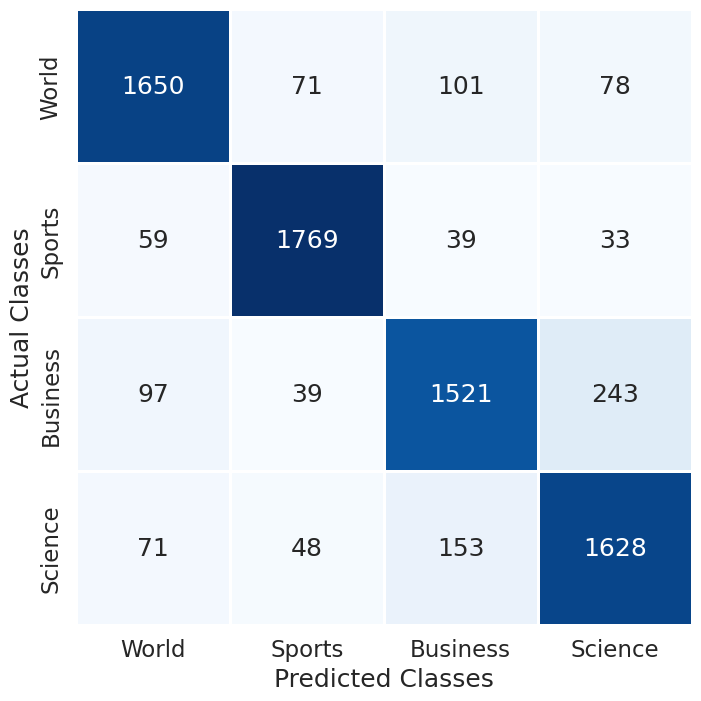

In [26]:
confusion_mat('Blues')

In [27]:
import pickle
import joblib
import json
from datetime import datetime

with open('knn_model.pkl', 'wb') as f:
    pickle.dump(KNN, f)
print("✓ Đã lưu KNN model bằng pickle")

joblib.dump(KNN, 'knn_model.joblib')
print("✓ Đã lưu KNN model bằng joblib")

joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
print("✓ Đã lưu TF-IDF vectorizer")

joblib.dump(selector, 'chi2_selector.joblib')
print("✓ Đã lưu Chi2 feature selector")

model_info = {
    'model_type': 'KNeighborsClassifier',
    'model_params': {
        'n_neighbors': KNN.n_neighbors,
        'metric': KNN.metric,
        'weights': KNN.weights,
        'algorithm': KNN.algorithm,
        'leaf_size': KNN.leaf_size,
        'p': KNN.p
    },
    'tfidf_params': {
        'min_df': tfidf.min_df,
        'ngram_range': tfidf.ngram_range,
        'max_features': tfidf.max_features,
        'total_features': len(tfidf.vocabulary_)
    },
    'feature_selection': {
        'method': 'chi2',
        'k_features': k,
        'selected_features': selected_features,
        'feature_ratio': float(feature_ratio)
    },
    'training_info': {
        'train_samples': len(train_y),
        'test_samples': len(test_y),
        'num_classes': len(train_y.unique()),
        'classes': train_y.unique().tolist()
    },
    'performance': {
        'test_accuracy': float(c/100)
    },
    'saved_date': datetime.now().strftime('%Y-%m-%d %H:%M:%S')
}

# Lưu metadata dạng JSON
with open('model_info.json', 'w', encoding='utf-8') as f:
    json.dump(model_info, f, indent=4, ensure_ascii=False)
print("✓ Đã lưu thông tin mô hình")

selected_features_dict = {
    'total_features': total_features,
    'selected_features': selected_features,
    'feature_names': selected_feature_names.tolist()
}

with open('selected_features.json', 'w', encoding='utf-8') as f:
    json.dump(selected_features_dict, f, indent=4, ensure_ascii=False)
print("✓ Đã lưu danh sách features đã chọn")

all_models = {
    'knn': KNN,
    'tfidf': tfidf,
    'selector': selector,
    'metadata': model_info
}

joblib.dump(all_models, 'complete_pipeline.joblib')
print("✓ Đã lưu toàn bộ pipeline vào 1 file")

print("\n" + "="*50)
print("HOÀN TẤT! Các file đã được lưu:")
print("="*50)
print("1. knn_model.pkl - Mô hình KNN (pickle)")
print("2. knn_model.joblib - Mô hình KNN (joblib)")
print("3. tfidf_vectorizer.joblib - TF-IDF vectorizer")
print("4. chi2_selector.joblib - Chi2 feature selector")
print("5. model_info.json - Thông tin chi tiết mô hình")
print("6. selected_features.json - Danh sách features")
print("7. complete_pipeline.joblib - Toàn bộ pipeline")


✓ Đã lưu KNN model bằng pickle
✓ Đã lưu KNN model bằng joblib
✓ Đã lưu TF-IDF vectorizer
✓ Đã lưu Chi2 feature selector
✓ Đã lưu thông tin mô hình
✓ Đã lưu danh sách features đã chọn
✓ Đã lưu toàn bộ pipeline vào 1 file

HOÀN TẤT! Các file đã được lưu:
1. knn_model.pkl - Mô hình KNN (pickle)
2. knn_model.joblib - Mô hình KNN (joblib)
3. tfidf_vectorizer.joblib - TF-IDF vectorizer
4. chi2_selector.joblib - Chi2 feature selector
5. model_info.json - Thông tin chi tiết mô hình
6. selected_features.json - Danh sách features
7. complete_pipeline.joblib - Toàn bộ pipeline
